# Crew size prediction

**Objective:** Build a regressor that recommends the “crew” size for potential ship buyers.
Your solution should address at least the following steps:
- Read the dataset and display columns.
- Analyze the data and state your observations.
- Select columns that are probably important to predict “crew” size. You can also remove columns or create new ones, motivating your choices.
- Create training and test sets.
- Train a Machine Learning model to predict the “crew” size.
- Evaluate your model on the test set, describing the metrics you are using and why you are using them. Comment on the results.

----

### Imports

In [210]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

### Setup

In [92]:
SEED = 42
DATA_DIR = Path('data')
DATA_FILE = DATA_DIR / 'home_work.csv'

In [93]:
df = pd.read_csv(DATA_FILE)

- Create trainining and test sets.

In [94]:
# Split data into train and test
train, test = train_test_split(df, test_size=0.2, random_state=SEED)

# Save train and test data
train.to_csv(DATA_DIR / 'train.csv', index=False)
test.to_csv(DATA_DIR / 'test.csv', index=False)

# EDA 

-  Read the dataset and display columns

In [95]:
train_df = pd.read_csv(DATA_DIR / 'train.csv')

In [96]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          126 non-null    object 
 1   Cruise_line        126 non-null    object 
 2   Age                126 non-null    int64  
 3   Tonnage            126 non-null    float64
 4   passengers         126 non-null    float64
 5   length             126 non-null    float64
 6   cabins             126 non-null    float64
 7   passenger_density  126 non-null    float64
 8   crew               126 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 9.0+ KB


- Analyze the data and state your observations.

We will start with an exploratory data analysis (EDA) to gather a better understanding of our training data. We will use the test data only for evaluating our models. On a first look we can see that the dataset is quite small, there are no null values and the features have various nature (object, float and int). 
Now let us take a look at our target variable `crew`.

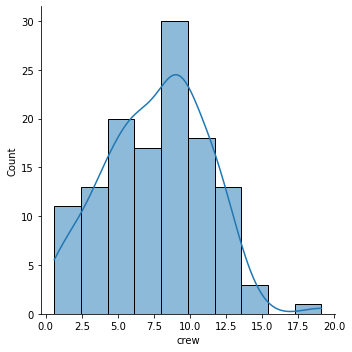

In [97]:
sns.displot(train_df['crew'], kde=True)
plt.show()

It is not perfectly normally distributed, but it is close enough. We will investigate this further later.

Now we can examine how the target variable correlates to the other features. Before doing that let's take a loog at the catagorical features (those with type `obj`). 

In [99]:
print(df['Ship_name'].nunique())
print(df['Cruise_line'].nunique())

138
20


We can safely assume that the `Ship_name` variable should not be useful for predicting the crew size. However, the `Cruise_line` may be of interest since the crew size may depend also on the type of services offered by the specific cruise line. We have to investigate more about this. Let's first see how the frequencies of the cruise lines. 

In [100]:
print(df['Cruise_line'].value_counts())

Royal_Caribbean      23
Carnival             22
Princess             17
Holland_American     14
Norwegian            13
Costa                11
Celebrity            10
MSC                   8
Star                  6
P&O                   6
Regent_Seven_Seas     5
Silversea             4
Oceania               3
Seabourn              3
Windstar              3
Cunard                3
Disney                2
Crystal               2
Azamara               2
Orient                1
Name: Cruise_line, dtype: int64


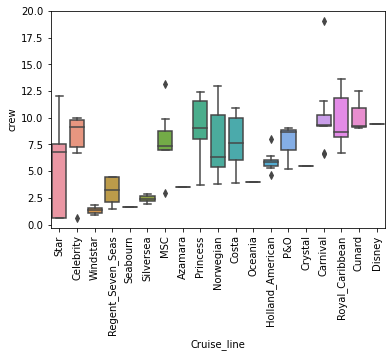

In [101]:
sns.boxplot(x='Cruise_line', y='crew', data=train_df.sort_values('crew'))
plt.xticks(rotation=90)
plt.show()

From the previous plot we can see that some lines have bigger crews. The matter of keeping the `Cruise_line` feature or not depends a lot on whether ship buyers are the same lines we have in our dataset. If they are not, then we should not keep this feature. We will assume this is the case for keeping the analysis more general, therefore we will keep the `Cruise_line` feature.

In [102]:
# Drop the Ship_name and Cruise_line columns
train_df = train_df.drop(['Ship_name', 'Cruise_line'], axis=1)

Now let's take a look at the other features. We want to see how they correlate to the target variable.

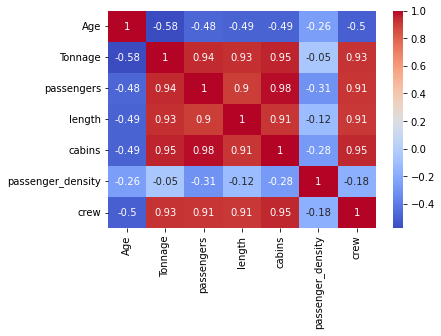

In [103]:
# Correlation matrix 
corr = train_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

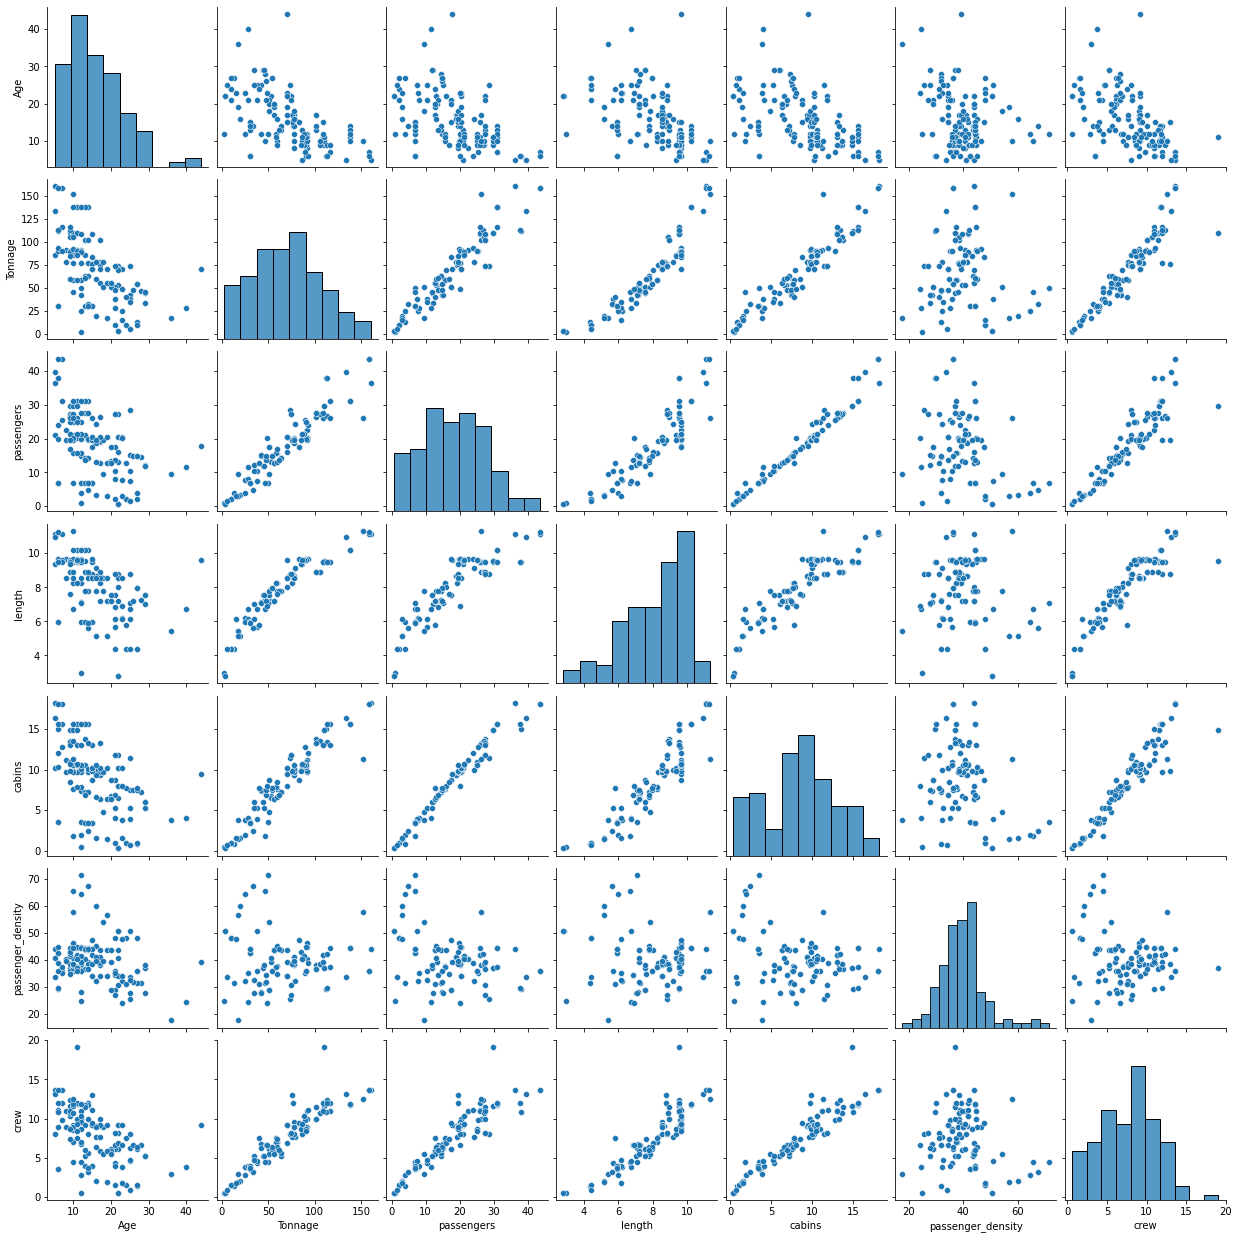

In [104]:
# Pairplot
sns.pairplot(train_df)
plt.show()

Some comments about the previous plot:
- The `Age` feature is negatively correlated with all the other variables. This is expected since older ships are smaller, have less passengers and smaller crews. 
- Passengers and cabin almost perfectly correlate with each other, so we can drop one of them since they carry the same information.  
- Tonnage, passengers, lenght and cabins are positively correlated with the crew size. This is expected since bigger ships have more passengers and crew.
- The passenger density feature has correlation almost zero with all the other features.

In [105]:
# Drop the cabins column
train_df = train_df.drop('cabins', axis=1)

### Dimensionality reduction 
We will apply a dimensionality reduction technique to visualize the data in a 2D space. We will use the PCA algorithm. 

In [106]:
# Apply PCA to the train dataset

pca = PCA(n_components=2)
pca.fit(train_df.drop('crew', axis=1))
pca_train = pca.transform(train_df.drop('crew', axis=1))


In [107]:
# Print the explained variance ratio   
print(pca.explained_variance_ratio_)

[0.92436495 0.05471816]


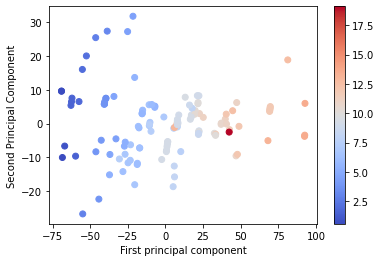

In [108]:
# Plot 
plt.scatter(pca_train[:, 0], pca_train[:, 1], c=train_df['crew'], cmap='coolwarm')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.show()

We can see that the PCA algorithm has separated the data in two clusters. The first cluster contains the ships with the biggest crew size and the second cluster contains the ships with the smallest crew size. We could use this information to build a simple model that predicts the crew size based on the PCA components. However, we will not do that since we lose interpretability of the model.

### Target variable transformation
It is common to try to transform the target variable to make it more Gaussian-like. This is because many machine learning algorithms such as linear regression assume that the target variable is normally distributed. 

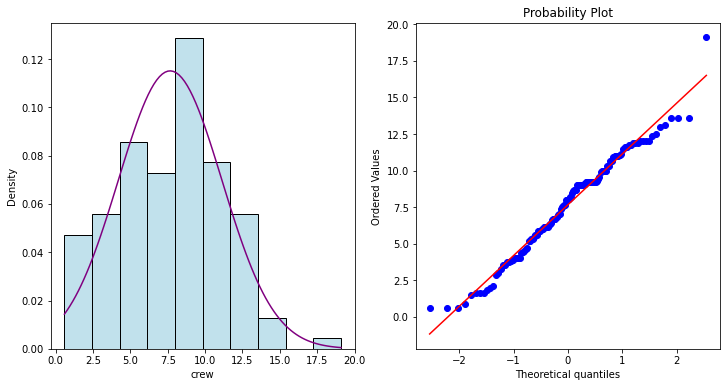

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
xx = np.linspace(train_df['crew'].min(), train_df['crew'].max(), 100)
sns.histplot(train_df['crew'], ax=ax1, stat='density', color='lightblue')
ax1.plot(xx, stats.norm.pdf(xx, train_df['crew'].mean(), train_df['crew'].std()), color='purple')
stats.probplot(train_df['crew'], plot=ax2)
plt.show()


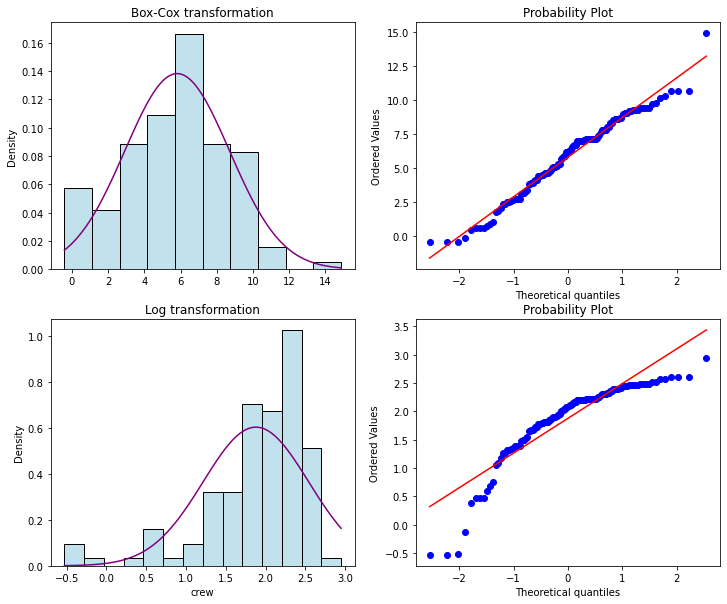

In [122]:
from scipy.stats import boxcox

boxcox_crew = boxcox(train_df['crew'])[0]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
xx = np.linspace(boxcox_crew.min(), boxcox_crew.max(), 100)
sns.histplot(boxcox_crew, ax=axs[0][0], stat='density', color='lightblue').set_title('Box-Cox transformation')
axs[0][0].plot(xx, stats.norm.pdf(xx, boxcox_crew.mean(), boxcox_crew.std()), color='purple')
stats.probplot(boxcox_crew, plot=axs[0][1])

# Second row with log transformation
log_crew = np.log(train_df['crew'])

xx = np.linspace(log_crew.min(), log_crew.max(), 100)
sns.histplot(log_crew, ax=axs[1][0], stat='density', color='lightblue').set_title('Log transformation')
axs[1][0].plot(xx, stats.norm.pdf(xx, log_crew.mean(), log_crew.std()), color='purple')
stats.probplot(log_crew, plot=axs[1][1])
plt.show()


Neither the log or the boxcox transformations are able to make the target variable more Gaussian-like. Therefore, we will not apply any transformation to the target variable.

# Model training
- Train a Machine Learning model to predict the “crew” size.

We will train a (ridge) linear regression model and a random forest model. Since the dataset is very small we need to avoid overfitting. Therefore we will use $k$-fold cross validation to evaluate the models and MAE as the metric to evaluate the models since it is more robust to outliers than the MSE. We will also use the $R^2$ score to evaluate the models, since it is a common metric to evaluate regression models. It expresses the percentage of the variance in the target variable that is predictable from the input variables.

In [197]:
# Split in X and y
X = train_df.drop('crew', axis=1)
y = train_df['crew']

In [211]:
# Lasso regression
lasso = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)
lasso.fit(X, y)

# Random forest
rf = RandomForestRegressor(random_state=SEED)
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

rf_gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
rf_gs.fit(X, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=1, min_s

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 50, 100]},
             verbose=2)

In [242]:
def mae_cv_score(model, X, y):
    """
    Prints mean +- std of MAE for 5-fold cross validation
    """
    mae = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=5)
    print(f'MAE: {mae.mean():.3f} +- {mae.std():.3f}')

def r2_cv_score(model, X, y):
    """
    Prints mean +- std of R2 for 5-fold cross validation
    """
    r2 = cross_val_score(model, X, y, scoring='r2', cv=5)
    print(f'R2: {r2.mean():.3f} +- {r2.std():.3f}')

In [243]:
# Print the MAE and R2 scores for Lasso regression
mae_cv_score(lasso, X, y)
r2_cv_score(lasso, X, y)

# Print the MAE and R2 scores for Random Forest
mae_cv_score(rf_gs.best_estimator_, X, y)
r2_cv_score(rf_gs.best_estimator_, X, y)


MAE: 0.761 +- 0.194
R2: 0.886 +- 0.077
MAE: 0.574 +- 0.107
R2: 0.911 +- 0.059


In [244]:
# Evaluate the models on the test set
test_df = pd.read_csv(DATA_DIR / 'test.csv')

# Drop the Ship_name and Cruise_line columns
test_df = test_df.drop(['Ship_name', 'Cruise_line'], axis=1)
# Drop the cabins column
test_df = test_df.drop('cabins', axis=1)

# Split in X and y
X_test = test_df.drop('crew', axis=1)
y_test = test_df['crew']

# Print mae and r2 scores on the test set
print(f'Lasso regression MAE: {np.mean(np.abs(lasso.predict(X_test) - y_test)):.2f}')
print(f'Lasso regression R2: {r2_score(y_test, lasso.predict(X_test)):.2f}')
print(f'Random forest MAE: {np.mean(np.abs(rf_gs.best_estimator_.predict(X_test) - y_test)):.2f}')
print(f'Random forest R2: {r2_score(y_test, rf_gs.best_estimator_.predict(X_test)):.2f}')


Lasso regression MAE: 0.90
Lasso regression R2: 0.85
Random forest MAE: 1.21
Random forest R2: 0.67


We can see that while during the validation part the random forest model performs better than the linear regression model, during the test part the linear regression model performs better. This is probably due to the fact that the random forest model is overfitting the training data. 
Therefore, we will choose the linear regression model as our final model, since it is simpler, more interepretable and it performs better on the test data. 
